# Notebook 1: Baseline Model & Metrics

## 1. Setup

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

## 2. Load Data

In [4]:
train = pd.read_csv("churn_train.csv", na_values=[], keep_default_na=False)
test = pd.read_csv("churn_test.csv", na_values=[], keep_default_na=False)

In [5]:
train.head(5)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## 3. Preprocessing

In [6]:
def preprocess(df):
    df = df.copy()
    df['Churn'] = df['Churn'].map({True: 1, False: 0})
    df['International plan'] = df['International plan'].map({'Yes': 1, 'No': 0})
    df['Voice mail plan'] = df['Voice mail plan'].map({'Yes': 1, 'No': 0})
    df = df.drop(columns=['State'])  # Drop high cardinality feature for now
    return df

In [7]:
train = preprocess(train)
test = preprocess(test)

In [8]:
train.head(5)

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [9]:
X_train = train.drop('Churn', axis=1)
y_train = train['Churn']
X_test = test.drop('Churn', axis=1)
y_test = test['Churn']

In [10]:
X_train.head(5)

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [11]:
y_train.head(5)

0    0
1    0
2    0
3    0
4    0
Name: Churn, dtype: int64

## Helper function for evaluation

In [12]:
def evaluate_model(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]
    print(f"\n--- {title} ---")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.title(f"Confusion Matrix - {title}")
    plt.show()
    print("ROC-AUC:", roc_auc_score(y_test, y_scores))
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.plot(fpr, tpr)
    plt.title(f"ROC Curve - {title}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

## 4. Train Uncalibrated Model on SMOTE Data

In [13]:
from imblearn.over_sampling import SMOTE

In [14]:
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train)
model = RandomForestClassifier(random_state=42)
model.fit(X_sm, y_sm)
y_proba_uncal = model.predict_proba(X_test)[:, 1]

## 5. Calibrate Model (Platt Scaling)

In [16]:
from sklearn.calibration import CalibratedClassifierCV

In [20]:
calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv=3)
calibrated_model.fit(X_sm, y_sm)
y_proba_cal = calibrated_model.predict_proba(X_test)[:, 1]


--- Balanced Random Forest Only (HPO) ---
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       572
           1       0.73      0.86      0.79        95

    accuracy                           0.93       667
   macro avg       0.85      0.90      0.87       667
weighted avg       0.94      0.93      0.94       667



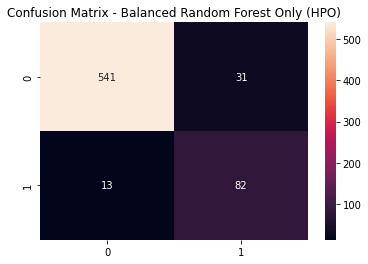

ROC-AUC: 0.9272911299227088


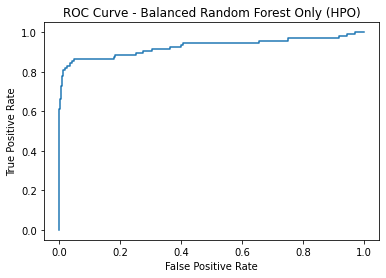

In [24]:
brf_params = {'n_estimators': [20, 50, 100, 150], 'max_depth': [None, 10, 20, 30]}
gs_brf = GridSearchCV(BalancedRandomForestClassifier(random_state=42), brf_params, scoring='roc_auc', cv=3, n_jobs=-1)
gs_brf.fit(X_train, y_train)
evaluate_model(gs_brf.best_estimator_, X_test, y_test, "Balanced Random Forest Only (HPO)")

## 6. Calibration Curve Plot

In [21]:
from sklearn.calibration import calibration_curve

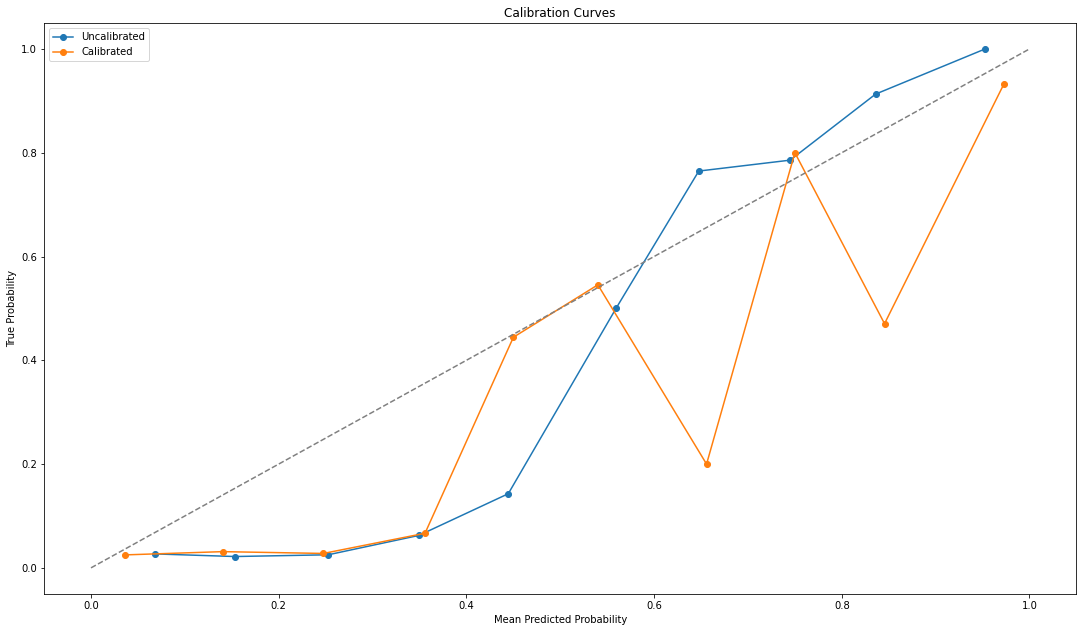

In [29]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

prob_true, prob_pred = calibration_curve(y_test, y_proba_uncal, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated')
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_proba_cal, n_bins=10)
plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Calibration Curves")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("True Probability")
plt.legend()
plt.show()

## 7. Brier Scores

In [23]:
print("Brier Score (Uncalibrated):", brier_score_loss(y_test, y_proba_uncal))
print("Brier Score (Calibrated):", brier_score_loss(y_test, y_proba_cal))

Brier Score (Uncalibrated): 0.07213463268365816
Brier Score (Calibrated): 0.057357242488582275


## 8. Threshold Tuning Example


Threshold: 0.2
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       572
           1       0.50      0.86      0.64        95

    accuracy                           0.86       667
   macro avg       0.74      0.86      0.77       667
weighted avg       0.91      0.86      0.87       667



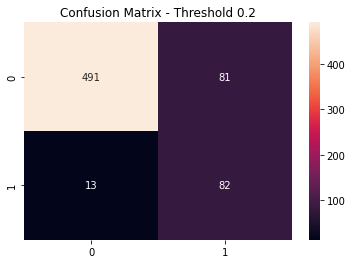


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       572
           1       0.64      0.85      0.73        95

    accuracy                           0.91       667
   macro avg       0.81      0.89      0.84       667
weighted avg       0.93      0.91      0.92       667



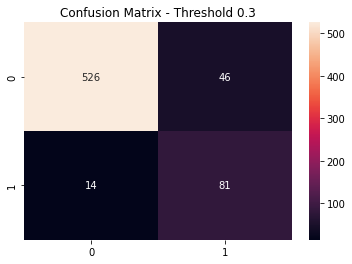


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       572
           1       0.71      0.84      0.77        95

    accuracy                           0.93       667
   macro avg       0.84      0.89      0.87       667
weighted avg       0.94      0.93      0.93       667



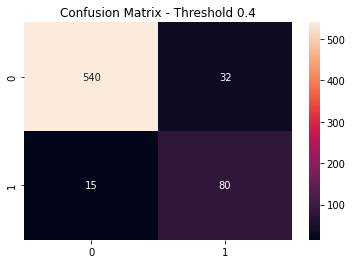


Threshold: 0.5
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       572
           1       0.74      0.80      0.77        95

    accuracy                           0.93       667
   macro avg       0.85      0.88      0.86       667
weighted avg       0.93      0.93      0.93       667



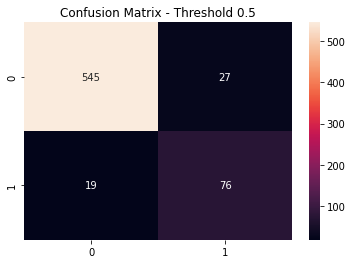


Threshold: 0.6
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       572
           1       0.76      0.74      0.75        95

    accuracy                           0.93       667
   macro avg       0.86      0.85      0.85       667
weighted avg       0.93      0.93      0.93       667



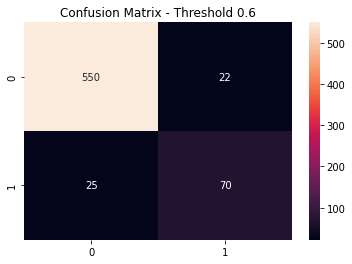

In [25]:
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for t in thresholds:
    preds = (y_proba_cal >= t).astype(int)
    print(f"\nThreshold: {t}")
    print(classification_report(y_test, preds))
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d')
    plt.title(f"Confusion Matrix - Threshold {t}")
    plt.show()

## 9. Precision-Recall curve

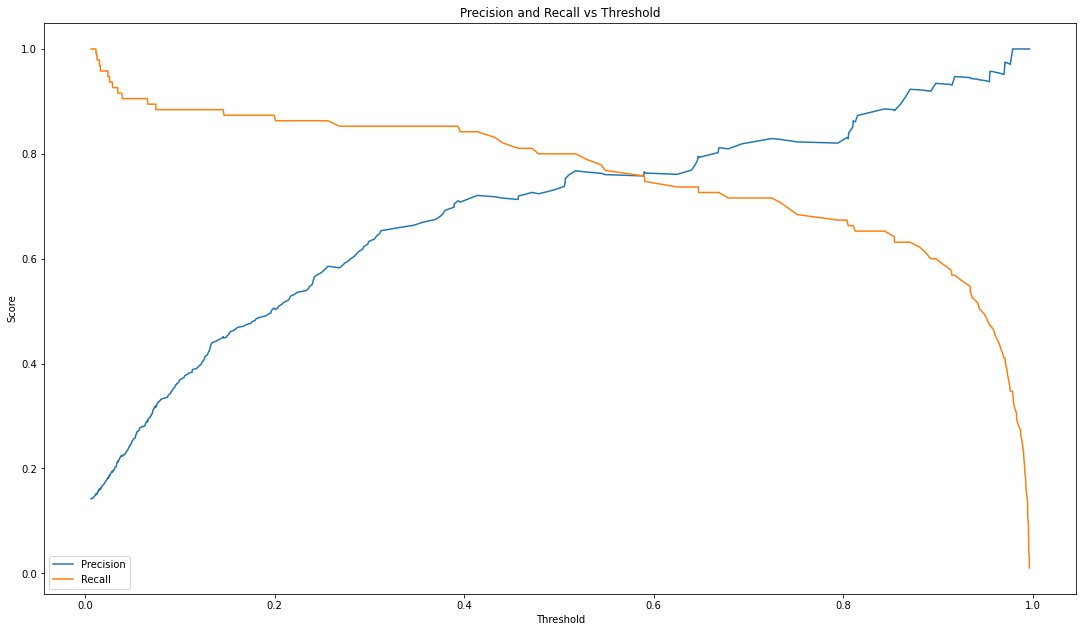

In [28]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

precision, recall, pr_thresh = precision_recall_curve(y_test, y_proba_cal)
plt.plot(pr_thresh, precision[:-1], label='Precision')
plt.plot(pr_thresh, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.show()